#### Imports

In [ ]:
import sys, os, json, time, copy
import numpy as np
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt
import torch as th

# SB3
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor

# Utils and CityLearn
from utils.env_utils import keep_only_electrical_storage, keep_only_core_observations, PowerScaledDiscreteActions
import citylearn
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper

print('Python:', sys.version.split()[0])
print('Torch :', th.__version__)
print('CityLearn:', citylearn.__version__)

Couldn't import dot_parser, loading of dot files will not be possible.


2025-09-18 10:11:36.749681: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-18 10:11:36.773564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758183096.801908 3722976 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758183096.810193 3722976 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758183096.830889 3722976 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Python: 3.11.7
Torch : 2.7.0+cu126
CityLearn: 2.4.1


#### Variables

In [ ]:
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'  # adjust if needed
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
LOG_DIR = r'/hkfs/home/haicore/iai/cj9272/logs/a2c'
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv'
ONLY_ELECTRICAL_STORAGE = True
EVAL_EPISODES = 20
ACTION_LABELS = ['discharge_full','discharge_half','idle','charge_half','charge_full']
NAME_TO_FRAC = {
    'discharge_full': -1.0,
    'discharge_half': -0.5,
    'idle': 0.0,
    'charge_half': 0.5,
    'charge_full': 1.0,
}
INT_TO_FRAC = np.array([NAME_TO_FRAC[n] for n in ACTION_LABELS], dtype=np.float32)

In [3]:
# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)
schema['root_directory'] = ROOT_DIR
schema['reward_function'] = REWARD_FN

# Set pricing file on all buildings
price_file = PRICING_FILE
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

# Narrow to electrical storage and core observations (same as other notebooks)
schema = keep_only_electrical_storage(schema)
schema = keep_only_core_observations(schema, extra_keep=['carbon_intensity', 'non_shiftable_load'], drop_predictions=False)

# Keep only one building for Discrete(5)
one_building = "Building_1"
schema_1b = dict(schema)
schema_1b['buildings'] = {k: v for k, v in schema['buildings'].items() if k == one_building}
if not schema_1b['buildings']:
    raise RuntimeError(f"{one_building} not found in schema['buildings']")

# Create base env
env = CityLearnEnv(schema_1b, central_agent=True)

# Debug
print('Initial time step:', env.time_step)
print('Number of time steps:', env.time_steps)
print('Central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))
print('Electrical storage capacity:', {b.name: b.electrical_storage.capacity for b in env.buildings})
print('Action_space:', env.action_space)
print('Number of Observations:', len(env.observations[0]))

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-09-18_10-11-42'
Initial time step: 0
Number of time steps: 2208
Central agent: True
Number of buildings: 1
Electrical storage capacity: {'Building_1': 4.0}
Action_space: [Box(-1.0, 1.0, (1,), float32)]
Number of Observations: 6


In [ ]:
import os, csv, time
import numpy as np
import pandas as pd
from stable_baselines3.common.callbacks import BaseCallback
from citylearn.citylearn import CityLearnEnv

class TrainStepCSVLogger(BaseCallback):
    """Pro-Schritt-Logger -> logs/<subdir>/train_steps.csv (VecEnv + Monitor kompatibel)."""
    def __init__(
        self,
        save_dir="logs/a2c",
        filename="train_steps.csv",
        action_labels=None,
        action_fracs=None,
        flush_every_steps=5000,
        verbose=0
    ):
        super().__init__(verbose)
        self.save_dir = save_dir
        self.filepath = os.path.join(save_dir, filename)
        self.action_labels = action_labels or ['discharge_full','discharge_half','idle','charge_half','charge_full']
        self.action_fracs  = np.array(action_fracs if action_fracs is not None else [-1., -0.5, 0., 0.5, 1.], dtype=float)
        self.flush_every_steps = int(flush_every_steps)

        self._fh = None
        self._writer = None
        self._t0 = None
        self._current_ep_counts = None  # pro Env laufende Episodennummer
        self._rows = []  
        self.df = None
        self.ep_df = None

    # ---------- helpers ----------
    @staticmethod
    def _unwrap_to_citylearn(env):
        cur, seen = env, set()
        while cur is not None and id(cur) not in seen:
            seen.add(id(cur))
            if isinstance(cur, CityLearnEnv):
                return cur
            cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
        return None

    def _get_citylearn_env_for_idx(self, idx: int):
        venv = self.training_env
        base = None
        if hasattr(venv, "envs"):                
            base = self._unwrap_to_citylearn(venv.envs[idx])
        else:
            try:
                base = self._unwrap_to_citylearn(venv.get_attr("env")[idx])
            except Exception:
                base = None
        return base

    # ---------- SB3 hooks ----------
    def _on_training_start(self) -> None:
        os.makedirs(self.save_dir, exist_ok=True)
        self._t0 = time.time()
        n_envs = int(getattr(self.training_env, "num_envs", 1))
        self._current_ep_counts = [0]*n_envs

        new_file = not os.path.exists(self.filepath) or os.path.getsize(self.filepath) == 0
        self._fh = open(self.filepath, "a", newline="")
        self._writer = csv.writer(self._fh)
        if new_file:
            self._writer.writerow([
                "global_step","time_sec","env_id","episode",
                "action_id","action_label","action_frac","reward",
                # CityLearn internals (t-1; konsistent mit obs)
                "price","net_load","non_shiftable_load","cooling_load","heating_load","dhw_load",
                "chargers_load","storage_load","solar","battery_soc","battery_energy_balance",
                "simulate_power_outage","power_outage"
            ])
            self._fh.flush()

    def _on_step(self) -> bool:
        obs_vec = self.locals.get("new_obs")
        acts    = self.locals.get("actions")
        rews    = self.locals.get("rewards")
        dones   = self.locals.get("dones")
        infos   = self.locals.get("infos", [])
        step    = int(self.num_timesteps)

        n_envs = len(rews) if hasattr(rews, "__len__") else 1
        for idx in range(n_envs):
            act  = acts[idx] if hasattr(acts, "__len__") else acts
            rew  = rews[idx] if hasattr(rews, "__len__") else rews
            done = bool(dones[idx]) if hasattr(dones, "__len__") else bool(dones)

            try:
                a_id = int(act) if np.isscalar(act) else int(np.array(act).reshape(-1)[0])
            except Exception:
                a_id = None

            a_label = (self.action_labels[a_id] if (a_id is not None and 0 <= a_id < len(self.action_labels)) else None)
            a_frac  = (float(self.action_fracs[a_id]) if (a_id is not None and 0 <= a_id < len(self.action_fracs)) else None)

            row = {
                "global_step": step,
                "time_sec": f"{time.time()-self._t0:.3f}",
                "env_id": idx,
                "episode": self._current_ep_counts[idx],
                "action_id": (a_id if a_id is not None else ""),
                "action_label": a_label if a_label is not None else "",
                "action_frac": f"{a_frac:.1f}" if a_frac is not None else "",
                "reward": f"{float(rew):.6f}",
                # CityLearn internals
                "price": "", "net_load": "", "non_shiftable_load": "",
                "cooling_load": "", "heating_load": "", "dhw_load": "",
                "chargers_load": "", "storage_load": "", "solar": "",
                "battery_soc": "", "battery_energy_balance": "",
                "simulate_power_outage": "", "power_outage": ""
            }

            try:
                base = self._get_citylearn_env_for_idx(idx)
                if base is not None and len(base.buildings) > 0:
                    b = base.buildings[0]
                    t  = int(getattr(b, "time_step", 0))
                    tp = max(0, t-1)

                    chargers_arr = getattr(b, "_Building__chargers_electricity_consumption", None)
                    chargers_tp  = float(chargers_arr[tp]) if chargers_arr is not None else np.nan

                    row.update({
                        "price": float(b.pricing.electricity_pricing[tp]),
                        "net_load": float(b.net_electricity_consumption[tp]),
                        "non_shiftable_load": float(b.non_shiftable_load_device.electricity_consumption[tp]),
                        "cooling_load": float(b.cooling_device.electricity_consumption[tp]),
                        "heating_load": float(b.heating_device.electricity_consumption[tp]),
                        "dhw_load": float(b.dhw_device.electricity_consumption[tp]),
                        "chargers_load": chargers_tp,
                        "storage_load": float(b.electrical_storage.electricity_consumption[tp]),
                        "solar": float(b.solar_generation[tp]),
                        "battery_soc": float(b.electrical_storage.soc[tp]),
                        "battery_energy_balance": float(b.electrical_storage.energy_balance[tp]),
                        "simulate_power_outage": bool(getattr(b, 'simulate_power_outage', False)),
                        "power_outage": bool(getattr(b, 'power_outage', False)),
                    })
            except Exception:
                pass

            row_df = {
                "global_step": step,
                "env_id": idx,
                "episode": self._current_ep_counts[idx],
                "action_id": a_id if a_id is not None else None,
                "action_label": a_label if a_label is not None else None,
                "action_frac": float(a_frac) if a_frac is not None else None,
                "reward": float(rew),
                "price": row["price"] if row["price"] != "" else None,
                "net_load": row["net_load"] if row["net_load"] != "" else None,
                "non_shiftable_load": row["non_shiftable_load"] if row["non_shiftable_load"] != "" else None,
                "cooling_load": row["cooling_load"] if row["cooling_load"] != "" else None,
                "heating_load": row["heating_load"] if row["heating_load"] != "" else None,
                "dhw_load": row["dhw_load"] if row["dhw_load"] != "" else None,
                "chargers_load": row["chargers_load"] if row["chargers_load"] != "" else None,
                "storage_load": row["storage_load"] if row["storage_load"] != "" else None,
                "solar": row["solar"] if row["solar"] != "" else None,
                "battery_soc": row["battery_soc"] if row["battery_soc"] != "" else None,
                "battery_energy_balance": row["battery_energy_balance"] if row["battery_energy_balance"] != "" else None,
            }
            self._rows.append(row_df)

            self._writer.writerow([
                row["global_step"], row["time_sec"], row["env_id"], row["episode"],
                row["action_id"], row["action_label"], row["action_frac"], row["reward"],
                row["price"], row["net_load"], row["non_shiftable_load"], row["cooling_load"], row["heating_load"],
                row["dhw_load"], row["chargers_load"], row["storage_load"], row["solar"],
                row["battery_soc"], row["battery_energy_balance"],
                row["simulate_power_outage"], row["power_outage"]
            ])

            if done:
                self._current_ep_counts[idx] += 1

        if self.flush_every_steps and (self.num_timesteps % self.flush_every_steps == 0):
            self._fh.flush()
        return True

    def _on_training_end(self) -> None:
        if self._fh is not None:
            self._fh.flush()
            self._fh.close()
            self._fh = None
            self._writer = None
        if self._rows:
            self.df = pd.DataFrame(self._rows)
            self.ep_df = (self.df.groupby(["env_id","episode"], as_index=False)
                            .agg(ep_return=("reward","sum"),
                                ep_length=("reward","size")))

In [ ]:
# Build & Train A2C
def compute_action_scales(cl_env, alpha=0.8):
    """scale = alpha * (P_nom * dt / capacity). alpha<1 gibt Headroom -> weniger Clipping."""
    dt_h = cl_env.schema['seconds_per_time_step'] / 3600.0
    scales = []
    for b in cl_env.buildings:
        cap  = max(b.electrical_storage.capacity, 1e-9)   # kWh
        pnom = b.electrical_storage.nominal_power         # kW
        scales.append(alpha * (pnom * dt_h) / cap)
    return np.array(scales, dtype=np.float32)

os.makedirs(LOG_DIR, exist_ok=True)
scales = compute_action_scales(env) 
print("Action scales (pro Building):", scales)

train_env = NormalizedObservationWrapper(env)
train_env = StableBaselines3Wrapper(train_env)
train_env = PowerScaledDiscreteActions(train_env, scales=scales)
train_env = Monitor(train_env, filename=os.path.join(LOG_DIR, "monitor.csv"))
print('Train action_space:', train_env.action_space)       

#train_callback = A2CTrainLoggerCallback()  
train_callback = TrainStepCSVLogger(save_dir=LOG_DIR, filename="a2c_train_steps_02.csv", action_labels=ACTION_LABELS, action_fracs=INT_TO_FRAC)  
TOTAL_TIMESTEPS = 2207 * 50

model = A2C(
    policy='MlpPolicy',
    env=train_env,
    seed=0,
    learning_rate=0.0002288113668475521,
    gamma=0.9714474177006047,
    ent_coef=0.0,
    n_steps=96,
    vf_coef=0.8917730007820798,
    gae_lambda=0.9927325521002058,
    verbose=1,
    policy_kwargs=dict(net_arch=[256, 256], activation_fn=th.nn.ReLU),
    device="cpu",
)
TRAINING_FILE = "a2c_02" # num
TRAIN_STEPS_FILE = os.path.join(LOG_DIR, "a2c_train_steps_02.csv") # num
TRAIN_EPISODES_FILE = os.path.join(LOG_DIR, "a2c_train_episodes_02.csv") # num

Action scales (pro Building): [0.664]
Train action_space: Discrete(5)
Using cpu device
Wrapping the env in a DummyVecEnv.


In [ ]:
start_time = time.time()
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=train_callback)
print(f"Total time elapsed for {TOTAL_TIMESTEPS} steps: {(time.time()-start_time):.2f} seconds")
model.save(TRAINING_FILE)
print(f"A2C model saved to {os.path.abspath(TRAINING_FILE)}")

print("---------------Train callback: \n", train_callback.df)
print("---------------Episode rewards: \n", train_callback.ep_df)
# Save training logs
train_callback.df.to_csv(TRAIN_STEPS_FILE, index=False)
train_callback.ep_df.to_csv(TRAIN_EPISODES_FILE, index=False)

In [ ]:
# Check train_callback on training episodes
if hasattr(train_callback, 'ep_df') and len(train_callback.ep_df):
    ep_df = train_callback.ep_df
    first_n, last_n = 10, 10
    first_mean = ep_df['ep_return'].head(first_n).mean()
    last_mean  = ep_df['ep_return'].tail(last_n).mean()
    print(f'First {first_n} ep mean return: {first_mean:.3f}')
    print(f'Last  {last_n} ep mean return: {last_mean:.3f}')
    print('Learning indicator (last - first):', f'{(last_mean-first_mean):.3f}')
else:
    print('No episode returns in train_callback.ep_df')

#### Evaluation

In [7]:
schema_eval = copy.deepcopy(schema_1b)
eval_env = CityLearnEnv(schema_eval, central_agent=True)
eval_scales = compute_action_scales(eval_env) 

eval_env = NormalizedObservationWrapper(eval_env)
eval_env = StableBaselines3Wrapper(eval_env)
eval_env = PowerScaledDiscreteActions(eval_env, scales=eval_scales)

model = A2C.load(TRAINING_FILE)
print(f"A2C model loaded from {os.path.abspath(TRAINING_FILE)}")
EVAL_FILE = os.path.join(LOG_DIR, "a2c_eval_03.pkl")

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-09-18_10-12-08'
A2C model loaded from /hkfs/home/haicore/iai/cj9272/a2c_02


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [ ]:
# ca 30min
import pickle 
from citylearn.citylearn import CityLearnEnv

# Enhanced eval: collect actions/rewards and per-step obs series, optionally save to .pkl
def evaluate_with_metrics(model, env, episodes=5, deterministic=True, render=False, save_path=None):

    def action_to_frac(env, action):
        if isinstance(env.action_space, gym.spaces.Discrete):
            return np.array([INT_TO_FRAC[int(action)]], dtype=np.float32)
        elif isinstance(env.action_space, gym.spaces.MultiDiscrete):
            a = np.asarray(action, dtype=int)
            return INT_TO_FRAC[a]
        else:
            return np.asarray(action, dtype=np.float32)

    def _get_base_env(e):
        cur, seen = e, set()
        while cur is not None and id(cur) not in seen:
            seen.add(id(cur))
            if isinstance(cur, CityLearnEnv):
                return cur
            cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
        raise RuntimeError("CityLearnEnv not found inside wrappers.")

    base = _get_base_env(env)
    bld_names = [b.name for b in base.buildings]
    building_name = "Building_1" if "Building_1" in bld_names else bld_names[0]
    b_idx = bld_names.index(building_name)

    obs_names = getattr(base, "observation_names", None)
    if obs_names is None:
        raise AttributeError("CityLearnEnv has no 'observation_names'.")
    obs_b = obs_names[b_idx]
    name_to_idx = {n: i for i, n in enumerate(obs_b)}
    i_net = name_to_idx.get("net_electricity_consumption")
    if i_net is None:
        i_net = name_to_idx.get("net_electricity_consumption_without_storage")
    i_nsl   = name_to_idx.get("non_shiftable_load")
    i_price = name_to_idx.get("electricity_pricing")
    i_solar = name_to_idx.get("solar_generation")

    ep_metrics, all_step_rewards, all_kpis, all_actions = [], [], [], []
    ep_lengths = []
    actions_disc_list, ep_action_fracs = [], []
    ep_rewards_list = []
    ep_net_load, ep_non_shiftable_load, ep_price, ep_solar_generation = [], [], [], []

    t_global_start = time.time()

    for ep in range(1, episodes + 1):
        obs, _ = env.reset()
        done = False
        ep_ret, ep_len = 0.0, 0
        step_rewards = []
        action_list = []

        ep_actions_disc = []
        ep_fracs = []
        ep_net, ep_nsl, ep_prc, ep_sol = [], [], [], []

        t_ep_start = time.time()
        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)
            frac = action_to_frac(env, action)
            action_list.append(frac)

            obs, r, terminated, truncated, info = env.step(action)
            done = bool(terminated or truncated)

            # Discrete(5) single-building -> int id
            if isinstance(env.action_space, gym.spaces.Discrete):
                a_id = int(action)
            else:
                # Fallback: nearest bin for first dimension
                a_id = int(np.argmin(np.abs(INT_TO_FRAC - float(frac[0]))))

            ep_actions_disc.append(a_id)
            ep_fracs.append(float(INT_TO_FRAC[a_id]))
            ep_rewards = float(r)
            step_rewards.append(ep_rewards)
            ep_ret += ep_rewards
            ep_len += 1

            raw = base.observations[b_idx]
            ep_net.append(float(raw[i_net]) if i_net is not None else np.nan)
            ep_nsl.append(float(raw[i_nsl]) if i_nsl is not None else np.nan)
            ep_prc.append(float(raw[i_price]) if i_price is not None else np.nan)
            ep_sol.append(float(raw[i_solar]) if i_solar is not None else np.nan)

            if render:
                env.render()

        kpis = env.unwrapped.evaluate()
        all_kpis.append(kpis)
        all_actions.append(np.vstack(action_list))

        t_ep = time.time() - t_ep_start
        steps_per_sec = ep_len / max(t_ep, 1e-9)
        ep_metrics.append({
            'episode': ep, 'cumulative reward': ep_ret, 'length': ep_len,
            'mean_reward': ep_ret/ep_len if ep_len else np.nan,
            'min_step_reward': float(np.min(step_rewards)),
            'max_step_reward': float(np.max(step_rewards)),
            'std_step_reward': float(np.std(step_rewards)),
            'steps_per_sec': steps_per_sec, 'time_sec': t_ep
        })
        all_step_rewards.extend(step_rewards)

        # Store per-episode sequences
        ep_lengths.append(ep_len)
        actions_disc_list.append(np.asarray(ep_actions_disc, dtype=int))
        ep_action_fracs.append(np.asarray(ep_fracs, dtype=float))
        ep_rewards_list.append(np.asarray(step_rewards, dtype=float))
        ep_net_load.append(np.asarray(ep_net, dtype=float))
        ep_non_shiftable_load.append(np.asarray(ep_nsl, dtype=float))
        ep_price.append(np.asarray(ep_prc, dtype=float))
        ep_solar_generation.append(np.asarray(ep_sol, dtype=float))

        print(f"[Eval] Ep {ep}/{episodes} return={ep_ret:.3f} len={ep_len} "
              f"mean={ep_ret/ep_len:.3f} time={t_ep:.2f}s speed={steps_per_sec:.1f} steps/s")

    print(f"Total eval time: {time.time()-t_global_start:.2f}s  | Avg/ep: {(time.time()-t_global_start)/episodes:.2f}s")
    metrics_df = pd.DataFrame(ep_metrics)
    display(metrics_df)

    price_file = schema['buildings'][building_name]['pricing']
    price_path = os.path.join(ROOT_DIR, price_file)
    prc_df = pd.read_csv(price_path)
    T = len(prc_df)

    results = {
        'ep_lengths': np.asarray(ep_lengths, dtype=int),
        'actions_disc_list': actions_disc_list,
        'step_rewards': np.asarray(all_step_rewards, dtype=float),

        'ep_action_fracs': ep_action_fracs,
        'ep_rewards_list': ep_rewards_list,
        'ep_net_load': ep_net_load,
        'ep_non_shiftable_load': ep_non_shiftable_load,
        'ep_price': ep_price,
        'ep_solar_generation': ep_solar_generation,

        'price_df': prc_df,
        'episode_len': T,
        'building_name': building_name,

        'metrics_df': metrics_df,
        'episode_kpis': all_kpis,
    }

    if save_path is not None:
        tmp = save_path + ".tmp"
        with open(tmp, "wb") as f:
            pickle.dump(results, f)
        os.replace(tmp, save_path)  # atomic replace
        print(f"A2C eval results saved to {os.path.abspath(save_path)}")

    return metrics_df, np.array(all_step_rewards), all_kpis, all_actions

# Run eval and save
metrics_stoch, step_rewards_stoch, kpis_stoch, actions_stoch = evaluate_with_metrics(
    model, eval_env, episodes=EVAL_EPISODES, deterministic=False, save_path=EVAL_FILE
)

[Eval] Ep 1/10 return=-268.277 len=2207 mean=-0.122 time=136.11s speed=16.2 steps/s
[Eval] Ep 2/10 return=-268.541 len=2207 mean=-0.122 time=278.55s speed=7.9 steps/s
[Eval] Ep 3/10 return=-269.604 len=2207 mean=-0.122 time=187.92s speed=11.7 steps/s
[Eval] Ep 4/10 return=-269.094 len=2207 mean=-0.122 time=293.65s speed=7.5 steps/s
[Eval] Ep 5/10 return=-268.332 len=2207 mean=-0.122 time=137.23s speed=16.1 steps/s
[Eval] Ep 6/10 return=-269.451 len=2207 mean=-0.122 time=138.42s speed=15.9 steps/s
[Eval] Ep 7/10 return=-267.988 len=2207 mean=-0.121 time=140.20s speed=15.7 steps/s
[Eval] Ep 8/10 return=-269.778 len=2207 mean=-0.122 time=135.82s speed=16.2 steps/s
[Eval] Ep 9/10 return=-269.202 len=2207 mean=-0.122 time=133.21s speed=16.6 steps/s
[Eval] Ep 10/10 return=-268.254 len=2207 mean=-0.122 time=135.00s speed=16.3 steps/s
Total eval time: 1716.27s  | Avg/ep: 171.63s


,episode,cumulative reward,length,mean_reward,min_step_reward,max_step_reward,std_step_reward,steps_per_sec,time_sec
0,1,-268.277343,2207,-0.121557,-2.143981,0.244055,0.173149,16.214710,136.110975
1,2,-268.541395,2207,-0.121677,-1.971611,0.249441,0.170637,7.923253,278.547202
2,3,-269.603621,2207,-0.122158,-1.757477,0.240151,0.172303,11.744439,187.918726
3,4,-269.093649,2207,-0.121927,-1.936760,0.217895,0.171743,7.515704,293.651811
4,5,-268.331979,2207,-0.121582,-1.473281,0.224337,0.172894,16.082207,137.232412
5,6,-269.451381,2207,-0.122089,-2.134889,0.248667,0.174017,15.943867,138.423135
6,7,-267.987617,2207,-0.121426,-1.985311,0.254342,0.172562,15.741751,140.200416
7,8,-269.778456,2207,-0.122238,-1.729539,0.249441,0.174851,16.249671,135.818137
8,9,-269.201894,2207,-0.121976,-1.757477,0.221446,0.174503,16.567235,133.214746
9,10,-268.254207,2207,-0.121547,-2.205978,0.259698,0.169587,16.347736,135.003401


A2C eval results saved to /hkfs/home/haicore/iai/cj9272/logs/a2c/a2c_eval_03.pkl


In [16]:
# ca 5min
import numpy as np, gymnasium as gym

def action_hist(model, env):
    obs, _ = env.reset()
    counts = np.zeros(5, dtype=int)
    done = False
    while not done:
        a, _ = model.predict(obs, deterministic=False)
        if isinstance(env.action_space, gym.spaces.Discrete):
            counts[int(a)] += 1
        else:
            # falls MultiDiscrete o.ä.
            counts[int(a[0])] += 1
        obs, r, term, trunc, _ = env.step(a)
        done = bool(term or trunc)
    print("action counts:", counts, "proportions:", counts / counts.sum())

action_hist(model, eval_env)

action counts: [  31    0 1842  332    2] proportions: [0.01404622 0.         0.83461713 0.15043045 0.00090621]


In [16]:
def preview_rewards(model, env, steps=48, deterministic=True):
    obs, _ = env.reset()
    cum = 0.0
    for t in range(steps):
        action, _ = model.predict(obs, deterministic=deterministic)
        obs, r, done, trunc, info = env.step(action)
        # CityLearn gibt bei central_agent i.d.R. eine Liste zurück
        r = float(r[0]) if isinstance(r, (list, tuple, np.ndarray)) else float(r)
        cum += r
        print(f"[eval] t={t:04d} r={r:.4f}  cum={cum:.4f}")
        if done or trunc:
            print(f"[eval] episode end at t={t}, return={cum:.4f}")
            break

# Aufrufen, sobald model & eval_env bereit sind:
preview_rewards(model, eval_env, steps=96, deterministic=True)

[eval] t=0000 r=-0.0926  cum=-0.0926
[eval] t=0001 r=-0.0390  cum=-0.1317
[eval] t=0002 r=-0.0282  cum=-0.1599
[eval] t=0003 r=-0.0245  cum=-0.1844
[eval] t=0004 r=-0.0297  cum=-0.2141
[eval] t=0005 r=-0.0728  cum=-0.2870
[eval] t=0006 r=-0.1487  cum=-0.4357
[eval] t=0007 r=-0.0160  cum=-0.4516
[eval] t=0008 r=-0.3530  cum=-0.8046
[eval] t=0009 r=0.0060  cum=-0.7986
[eval] t=0010 r=0.0384  cum=-0.7602
[eval] t=0011 r=-0.0444  cum=-0.8046
[eval] t=0012 r=0.0046  cum=-0.8000
[eval] t=0013 r=0.0023  cum=-0.7977
[eval] t=0014 r=0.0057  cum=-0.7920
[eval] t=0015 r=-0.0591  cum=-0.8511
[eval] t=0016 r=-0.0552  cum=-0.9063
[eval] t=0017 r=-0.0448  cum=-0.9511
[eval] t=0018 r=-0.0519  cum=-1.0029
[eval] t=0019 r=-0.1467  cum=-1.1496
[eval] t=0020 r=-0.1280  cum=-1.2776
[eval] t=0021 r=-0.0908  cum=-1.3684
[eval] t=0022 r=-0.0546  cum=-1.4230
[eval] t=0023 r=-0.0793  cum=-1.5023
[eval] t=0024 r=-0.0706  cum=-1.5729
[eval] t=0025 r=-0.0417  cum=-1.6145
[eval] t=0026 r=-0.0293  cum=-1.6439
[eval]

#### Optuna

In [25]:
# Optuna objective + study creation for A2C (add as a new cell)
import os, copy, json
import numpy as np
import optuna
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler

WORKER_ID = int(os.getenv("OPTUNA_WORKER_ID", "0"))
ART_DIR = os.path.join(os.getcwd(), "artifacts")
os.makedirs(ART_DIR, exist_ok=True)
STORAGE_URL = f"sqlite:///{os.path.join(ART_DIR, 'optuna_a2c.db')}?timeout=120"
STUDY_NAME = "a2c_citylearn"

def make_env_one_building(schema_src, building_name="Building_1", n_bins=5, monitor=False):
    schema_1b = copy.deepcopy(schema_src)
    schema_1b['buildings'] = {k: v for k, v in schema_src['buildings'].items() if k == building_name}
    if not schema_1b['buildings']:
        raise RuntimeError(f"{building_name} not found in schema['buildings']")
    env = CityLearnEnv(schema_1b, central_agent=True)
    env_scales = compute_action_scales(env) 
    env = NormalizedObservationWrapper(env)
    env = StableBaselines3Wrapper(env)
    env = PowerScaledDiscreteActions(env, scales=env_scales)
    #env = DiscretizeActionWrapper(env, n_bins=n_bins)
    if monitor:
        env = Monitor(env)
    return env

def evaluate_mean_reward(model, env, episodes=2, deterministic=True):
    rewards = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        ep_ret = 0.0
        while not done:
            act, _ = model.predict(obs, deterministic=deterministic)
            obs, r, terminated, truncated, _ = env.step(act)
            ep_ret += float(r)
            done = bool(terminated or truncated)
        rewards.append(ep_ret)
    return float(np.mean(rewards))

class OptunaEvalPruningCallback:
    def __init__(self, trial, model, eval_env, eval_every_steps, eval_episodes=2):
        self.trial = trial
        self.model = model
        self.eval_env = eval_env
        self.eval_every_steps = int(eval_every_steps)
        self.eval_episodes = int(eval_episodes)
        self._last_step = 0
        self.is_pruned = False

    def __call__(self, locals_, globals_):
        # Called by SB3 when using callback= in learn (old-style callable)
        step = int(locals_.get("self").num_timesteps)
        if step - self._last_step >= self.eval_every_steps:
            self._last_step = step
            mean_r = evaluate_mean_reward(self.model, self.eval_env, episodes=self.eval_episodes, deterministic=True)
            self.trial.report(mean_r, step=step)
            if self.trial.should_prune():
                self.is_pruned = True
                return False  # stop training
        return True

def objective(trial: optuna.Trial) -> float:
    # Search space (A2C-relevant)
    lr        = trial.suggest_float("learning_rate", 1e-5, 3e-3, log=True)
    gamma     = trial.suggest_float("gamma", 0.90, 0.9999)
    ent_coef  = trial.suggest_float("ent_coef", 0.0, 0.1)
    n_steps   = trial.suggest_categorical("n_steps", [5, 16, 32, 64])
    vf_coef   = trial.suggest_float("vf_coef", 0.0, 1.0)
    gae_lambda= trial.suggest_float("gae_lambda", 0.8, 1.0)
    net_key   = trial.suggest_categorical("net_arch", ["128x128", "256x256", "256x256x256"])
    net_arch  = [int(x) for x in net_key.split("x")]

    # Build envs
    train_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=True)
    eval_env  = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
    T = train_env.unwrapped.time_steps

    # keep trials short
    episodes_per_trial = 3
    total_steps = episodes_per_trial * T

    model = A2C(
        policy="MlpPolicy",
        env=train_env,
        seed=0,
        learning_rate=lr,
        gamma=gamma,
        n_steps=n_steps,
        ent_coef=ent_coef,
        vf_coef=vf_coef,
        gae_lambda=gae_lambda,
        verbose=0,
        policy_kwargs=dict(net_arch=net_arch, activation_fn=th.nn.ReLU),
        device="auto",
    )

    cb = OptunaEvalPruningCallback(trial, model, eval_env, eval_every_steps=max(1, T//2), eval_episodes=2)
    try:
        model.learn(total_timesteps=total_steps, callback=cb)
        if cb.is_pruned:
            raise optuna.TrialPruned()
    finally:
        try: train_env.close()
        except: pass
        try: eval_env.close()
        except: pass

    # final evaluation
    eval_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
    score = evaluate_mean_reward(model, eval_env, episodes=3, deterministic=True)
    eval_env.close()

    trial.set_user_attr("final_mean_reward", score)
    return score

print(f"PID: {os.getpid()}")

study = optuna.create_study(
    study_name=STUDY_NAME,
    direction="maximize",
    storage=STORAGE_URL,
    load_if_exists=True,
    sampler=TPESampler(seed=None, multivariate=False),  # no fixed seed here
    pruner=SuccessiveHalvingPruner(min_resource=1, reduction_factor=3, min_early_stopping_rate=0),
)
print("Study ready:", STUDY_NAME, STORAGE_URL, "worker:", WORKER_ID)

[I 2025-09-16 11:35:10,247] Using an existing study with name 'a2c_citylearn' instead of creating a new one.


PID: 3915198
Study ready: a2c_citylearn sqlite:////hkfs/home/haicore/iai/cj9272/artifacts/optuna_a2c.db?timeout=120 worker: 0


In [ ]:
# Optuna hyperparameter optimization
#N_TRIALS = 30  # increase as needed
N_TRIALS = None  # let timeout drive the run
TIMEOUT_SECONDS = int((3*3600 + 40*60) / 2)  # 6600 seconds per worker
study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT_SECONDS, gc_after_trial=True, catch=(Exception,))
print("Done. Trials now:", len(study.trials))

In [4]:
# Print best Trial + Top 10 Trials and store best trial params in artifacts/best_params_*.json
import os, json
import optuna
from collections import defaultdict

ART_DIR = os.path.join(os.getcwd(), "artifacts")
STORAGE_URL = f"sqlite:///{os.path.join(ART_DIR, 'optuna_a2c.db')}?timeout=120"
STUDY_NAME = "a2c_citylearn"

try:
    study = optuna.load_study(study_name=STUDY_NAME, storage=STORAGE_URL)
except Exception as e:
    print("Study konnte nicht geladen werden:", e)
    raise

best = study.best_trial
print("Best trial number:", best.number)
print("Best value (objective):", best.value)
print("Best params:")
for k, v in best.params.items():
    print(f"  {k}: {v}")

# Top-K completed trials (by objective value)
top_k = 10
completed = [t for t in study.trials if t.value is not None]
completed_sorted = sorted(completed, key=lambda t: t.value, reverse=True)[:top_k]
print(f"\nTop {min(top_k, len(completed_sorted))} trials (number, value):")
for t in completed_sorted:
    print(f"  #{t.number}\t{t.value}\t{t.params}")

# Per-parameter summary (unique values seen)
param_vals = defaultdict(set)
for t in study.trials:
    for k, v in t.params.items():
        param_vals[k].add(v)

print("\nParameter summary (unique values seen):")
for k in sorted(param_vals.keys()):
    vals = list(param_vals[k])
    print(f"  {k}: {len(vals)} unique (examples: {vals[:6]})")

# Save best params to artifacts
os.makedirs(ART_DIR, exist_ok=True)
out_path = os.path.join(ART_DIR, f"best_params_{STUDY_NAME}.json")
with open(out_path, "w") as f:
    json.dump({"trial": int(best.number), "value": float(best.value), "params": best.params}, f, indent=2)
print("\nSaved best params to:", out_path)

Best trial number: 1
Best value (objective): -265.46900342672353
Best params:
  learning_rate: 0.0002288113668475521
  gamma: 0.9714474177006047
  ent_coef: 0.06027633760716439
  n_steps: 32
  vf_coef: 0.8917730007820798
  gae_lambda: 0.9927325521002058
  net_arch: 256x256

Top 10 trials (number, value):
  #1	-265.46900342672353	{'learning_rate': 0.0002288113668475521, 'gamma': 0.9714474177006047, 'ent_coef': 0.06027633760716439, 'n_steps': 32, 'vf_coef': 0.8917730007820798, 'gae_lambda': 0.9927325521002058, 'net_arch': '256x256'}
  #2	-265.46900342672353	{'learning_rate': 0.00025533788451512354, 'gamma': 0.9924671041654368, 'ent_coef': 0.007103605819788694, 'n_steps': 32, 'vf_coef': 0.8700121482468192, 'gae_lambda': 0.9957236684465528, 'net_arch': '128x128'}
  #3	-265.46900342672353	{'learning_rate': 1.9632702887198374e-05, 'gamma': 0.9639281100306196, 'ent_coef': 0.014335328740904641, 'n_steps': 5, 'vf_coef': 0.7742336894342167, 'gae_lambda': 0.8912300664433097, 'net_arch': '256x256x

#### Plots

Eval results loaded from /hkfs/home/haicore/iai/cj9272/logs/a2c/a2c_eval_03.pkl.


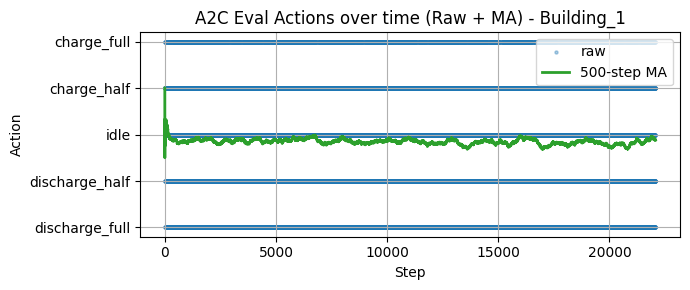

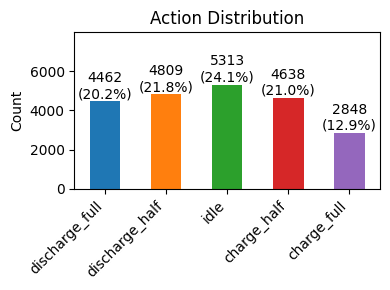

Eval results loaded from /hkfs/home/haicore/iai/cj9272/logs/a2c/a2c_eval_03.pkl.


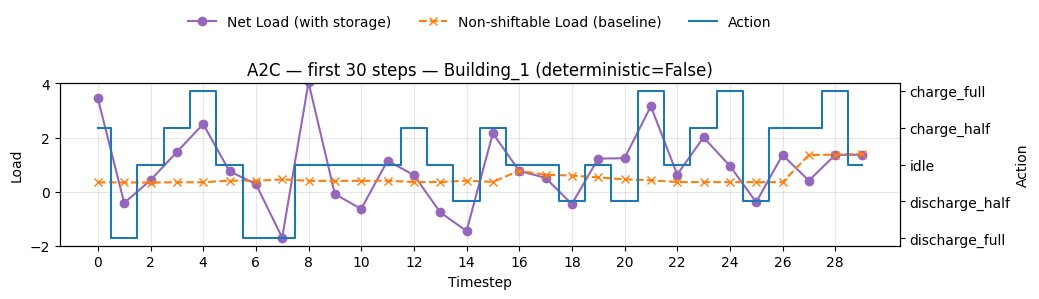

Eval results loaded from /hkfs/home/haicore/iai/cj9272/logs/a2c/a2c_eval_03.pkl.


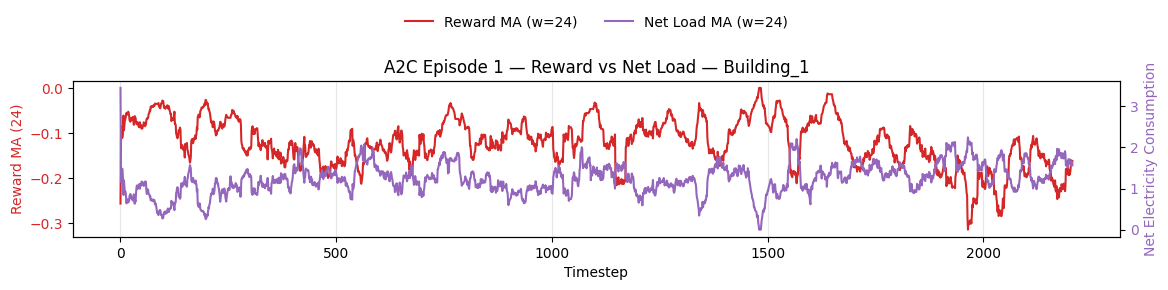

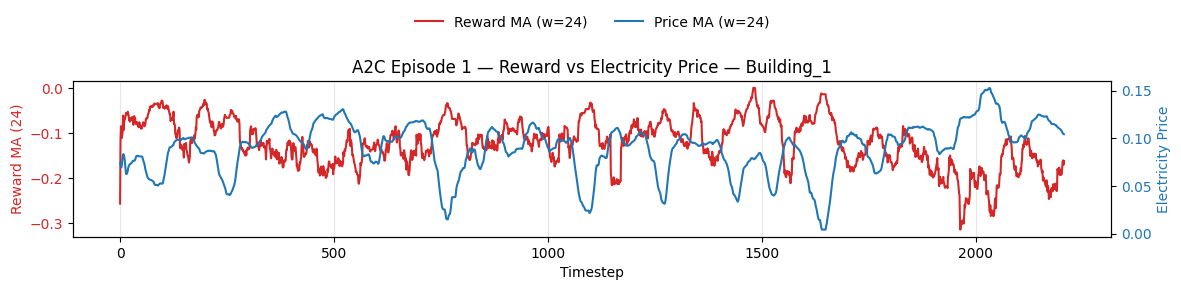

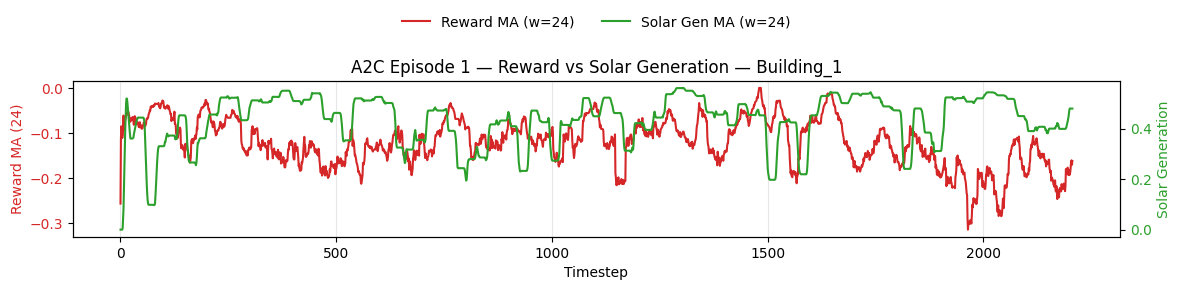

In [12]:
# ...existing code...
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from citylearn.citylearn import CityLearnEnv
from matplotlib.ticker import MultipleLocator

def load_a2c_eval_results(path=EVAL_FILE):
    """Load eval results from disk (no in-memory cache)."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found. Run evaluate_with_metrics(..., save_path=EVAL_FILE) first.")
    with open(path, "rb") as f:
        data = pickle.load(f)
    print(f"Eval results loaded from {os.path.abspath(path)}.")
    return data

# Load saved A2C eval to plot without re-evaluating
er = load_a2c_eval_results()

# Rebuild vars expected by plots
# actions_stoch: list[(ep_len, n_actions)] -> here n_actions=1 (single building)
if 'actions_disc_list' in er and er['actions_disc_list']:
    actions_stoch = [INT_TO_FRAC[np.asarray(ep, dtype=int)][:, None] for ep in er['actions_disc_list']]
elif 'ep_action_fracs' in er:
    actions_stoch = [np.asarray(ep, dtype=float)[:, None] for ep in er['ep_action_fracs']]
else:
    raise KeyError("No action sequences found in eval results.")

# metrics_stoch: DataFrame with at least 'length'
metrics_stoch = er.get('metrics_df', None)
if metrics_stoch is None or not isinstance(metrics_stoch, pd.DataFrame):
    ep_lengths = np.asarray(er.get('ep_lengths', [len(x) for x in actions_stoch]), dtype=int)
    metrics_stoch = pd.DataFrame({'episode': np.arange(1, len(ep_lengths)+1), 'length': ep_lengths})

# Prefer building name from file if present
building_name = er.get('building_name', 'Building_1')

def unwrap_to_citylearn(env):
    cur, seen = env, set()
    while cur is not None and id(cur) not in seen:
        seen.add(id(cur))
        if isinstance(cur, CityLearnEnv):
            return cur
        cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
    raise RuntimeError("CityLearnEnv not found inside wrappers.")


def capture_ep_series_a2c(building_name="Building_1", deterministic=True, max_steps=None, episode_idx=0, results_path=EVAL_FILE):
    """Build per-step DataFrame from saved eval_results; no env stepping or model usage."""
    er = load_a2c_eval_results(results_path)
    needed = [
        'ep_action_fracs', 'ep_rewards_list', 'ep_net_load',
        'ep_non_shiftable_load', 'ep_price', 'ep_solar_generation'
    ]
    missing = [k for k in needed if k not in er]
    if missing:
        raise ValueError(f"eval_results missing keys: {missing}. Re-run evaluate_with_metrics to regenerate.")
    n_eps = len(er['ep_rewards_list'])
    if not (0 <= episode_idx < n_eps):
        raise IndexError(f"episode_idx {episode_idx} out of range 0..{n_eps-1}")
    if 'actions_disc_list' in er and er['actions_disc_list'] and len(er['actions_disc_list']) > episode_idx:
        a_id = np.asarray(er['actions_disc_list'][episode_idx], dtype=int)
    else:
        frac = np.asarray(er['ep_action_fracs'][episode_idx], dtype=float)
        a_id = np.argmin(np.abs(frac[:, None] - INT_TO_FRAC[None, :]), axis=1)
    a_frac = np.asarray(er['ep_action_fracs'][episode_idx], dtype=float)
    rew    = np.asarray(er['ep_rewards_list'][episode_idx], dtype=float)
    net    = np.asarray(er['ep_net_load'][episode_idx], dtype=float)
    nsl    = np.asarray(er['ep_non_shiftable_load'][episode_idx], dtype=float)
    price  = np.asarray(er['ep_price'][episode_idx], dtype=float)
    solar  = np.asarray(er['ep_solar_generation'][episode_idx], dtype=float)
    L = len(rew)
    if max_steps is not None:
        L = min(L, int(max_steps))
        a_id, a_frac, rew, net, nsl, price, solar = (
            a_id[:L], a_frac[:L], rew[:L], net[:L], nsl[:L], price[:L], solar[:L]
        )
    df = pd.DataFrame({
        't': np.arange(L, dtype=int),
        'action_id': a_id,
        'action_frac': a_frac,
        'reward': rew,
        'net_load': net,
        'non_shiftable_load': nsl,
        'price': price,
        'solar_generation': solar,
    })
    return df, er.get('building_name', building_name)

def add_top_legend(ax_left, ax_right=None, ncol=3, y=1.50, top=0.84, loc='upper center', frameon=False):
    """Place a combined legend above the plot using lines from one or two axes."""
    handles = []
    for ax in (ax_left, ax_right):
        if ax is None:
            continue
        handles.extend(ax.get_lines())
    labels = [h.get_label() for h in handles]
    legend = ax_left.legend(handles, labels, loc=loc, bbox_to_anchor=(0.5, y), ncol=ncol, frameon=frameon)
    if top is not None:
        plt.subplots_adjust(top=top)
    return legend

# Choose a building to visualize
building_name = 'Building_1'
bld_names = [b.name for b in eval_env.unwrapped.buildings]
if building_name not in bld_names:
    building_name = bld_names[0]
b_idx = bld_names.index(building_name)

# Flatten evaluated actions across episodes -> shape (total_steps, n_actions)
# actions_stoch is collected by evaluate_with_metrics (fractions in [-1,1])
actions_arr = np.concatenate(actions_stoch, axis=0)  # each item shape (ep_len, n_actions)
n_actions = actions_arr.shape[1]
total_steps = actions_arr.shape[0]

# Build episode boundaries from metrics
ep_lengths = metrics_stoch['length'].to_numpy()
ep_offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))
hour_index = np.arange(total_steps)

# Load pricing for the chosen building
price_file = schema['buildings'][building_name]['pricing']
price_path = os.path.join(ROOT_DIR, price_file)
prc = pd.read_csv(price_path)
T = len(prc)  # 2208

# Helper: map continuous action to 5 labels by nearest of [-1,-0.5,0,0.5,1]
def frac_to_label_idx(vals: np.ndarray) -> np.ndarray:
    return np.argmin(np.abs(vals[..., None] - INT_TO_FRAC[None, :]), axis=-1)


# ----- Plot 1: Actions over Time (for selected building) -----
window = 500
act_series = actions_arr[:, b_idx]
act_ma = pd.Series(act_series).rolling(window, min_periods=1).mean().to_numpy()

plt.figure(figsize=(7,3))
plt.scatter(hour_index, act_series, s=5, alpha=0.35, label='raw')
plt.plot(hour_index, act_ma, color='C2', lw=2, label=f'{window}-step MA')
plt.title(f'A2C Eval Actions over time (Raw + MA) - {building_name}')
plt.xlabel('Step'); plt.ylabel('Action'); plt.grid(True); plt.legend(loc='upper right')
plt.yticks(ticks=INT_TO_FRAC.tolist(), labels=ACTION_LABELS)
plt.tight_layout(); plt.show()


# ----- Plot 2: Action Distribution (quantized to 5 bins like RBC) -----
plt.figure(figsize=(4,3))
labels_idx = frac_to_label_idx(act_series)
counts = pd.Series(labels_idx).value_counts().reindex(range(5)).fillna(0).astype(int)
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
ax.set_xticklabels(ACTION_LABELS, rotation=45, ha='right')
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution'); plt.tight_layout(); plt.show()


def plot_first_30_steps_actions_vs_loads_a2c(building_name="Building_1", deterministic=True):
    """Plot first 30 steps: net load vs non-shiftable load with action (discrete bins in [-1..1])."""
    df30, bname = capture_ep_series_a2c(building_name, deterministic=deterministic, max_steps=30)

    t = df30['t'].to_numpy()
    net = df30['net_load'].to_numpy()
    nsl = df30['non_shiftable_load'].to_numpy()
    act = df30['action_frac'].to_numpy()

    fig, ax1 = plt.subplots(figsize=(10.5, 3.6))
    ax1.plot(t, net, color='C4', marker='o', label='Net Load (with storage)')
    ax1.plot(t, nsl, color='C1', ls='--', marker='x', label='Non-shiftable Load (baseline)')
    ax1.set_xlabel('Timestep')
    ax1.set_xticks(t[::2])
    ax1.set_ylabel('Load')
    ax1.set_ylim(-2, 4)  # enforce requested load range
    ax1.yaxis.set_major_locator(MultipleLocator(2))  # enforce ticks every 2 units
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.step(t, act, where='mid', color='C0', label='Action')
    ax2.set_ylabel('Action')
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_yticks(INT_TO_FRAC.tolist())
    try:
        ax2.set_yticklabels(ACTION_LABELS)
    except Exception:
        ax2.set_yticklabels(['discharge_full','discharge_half','idle','charge_half','charge_full'])
    add_top_legend(ax1, ax2)
    plt.title(f'A2C — first 30 steps — {bname} (deterministic={deterministic})')
    plt.tight_layout()
    plt.show()

def plot_ep1_reward_vs_obs_a2c(building_name="Building_1", deterministic=True):
    """Three plots: Reward vs Price, Solar, Net for episode 1."""
    df, bname = capture_ep_series_a2c(building_name, deterministic=deterministic, max_steps=None)

    window_reward = 24
    window_x = 24
    t = df['t'].to_numpy()
    reward_ma = pd.Series(df['reward']).rolling(window_reward, min_periods=1).mean().to_numpy()
    price_ma  = pd.Series(df['price']).rolling(window_x, min_periods=1).mean().to_numpy()
    solar_ma  = pd.Series(df['solar_generation']).rolling(window_x, min_periods=1).mean().to_numpy()
    net_ma    = pd.Series(df['net_load']).rolling(window_x, min_periods=1).mean().to_numpy()

    # 4) Reward vs Net Load
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, net_ma, color='C4', label=f'Net Load MA (w={window_x})')
    ax2.set_ylabel('Net Electricity Consumption', color='C4'); ax2.tick_params(axis='y', labelcolor='C4')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'A2C Episode 1 — Reward vs Net Load — {bname}')
    plt.tight_layout(); plt.show()

    # 5) Reward vs Electricity Price
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, price_ma, color='C0', label=f'Price MA (w={window_x})')
    ax2.set_ylabel('Electricity Price', color='C0'); ax2.tick_params(axis='y', labelcolor='C0')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'A2C Episode 1 — Reward vs Electricity Price — {bname}')
    plt.tight_layout(); plt.show()

    # 6) Reward vs Solar Generation
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, solar_ma, color='C2', label=f'Solar Gen MA (w={window_x})')
    ax2.set_ylabel('Solar Generation', color='C2'); ax2.tick_params(axis='y', labelcolor='C2')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'A2C Episode 1 — Reward vs Solar Generation — {bname}')
    plt.tight_layout(); plt.show()


# ----- Plot 3: Actions vs Loads (first 30 steps) -----
plot_first_30_steps_actions_vs_loads_a2c(building_name="Building_1", deterministic=False)


# ----- Plot 4,5,6: Actions vs Observations(Net Load, Price, Solar Generation) - first episode -----
plot_ep1_reward_vs_obs_a2c(building_name="Building_1", deterministic=False)

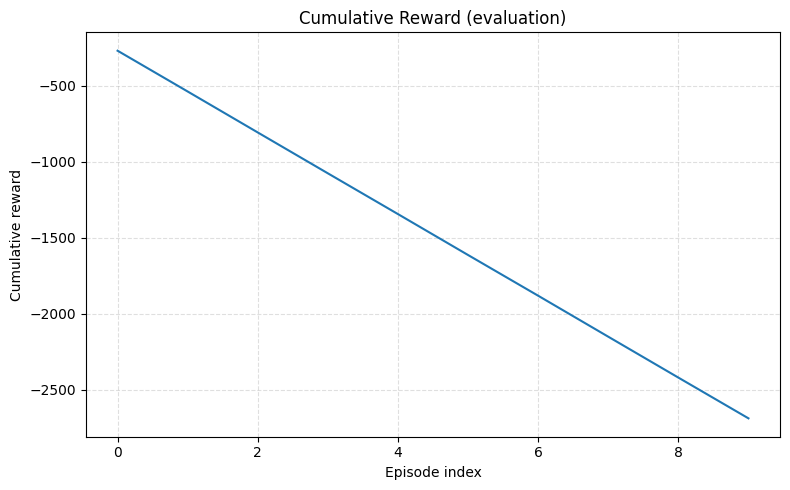

Episodes: 10 | Final cumulative reward: -2688.522


In [13]:
# Plot cumulative reward from DQN eval .pkl
# Uses keys present in your file: 'ep_rewards_list' (preferred)
# and falls back to ('step_rewards' + 'ep_lengths') if needed.

import os
import pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

p = Path(EVAL_FILE)
if not p.exists():
    raise FileNotFoundError(f"Eval file not found: {p.resolve()}")

with open(p, "rb") as f:
    data = pickle.load(f)

def to_1d_float_array(x):
    arr = np.asarray(x, dtype=float)
    return arr.ravel()

def extract_episode_returns(d):
    # Preferred: ep_rewards_list
    if isinstance(d, dict) and "ep_rewards_list" in d:
        ep = d["ep_rewards_list"]
        # ep can be: list[float] OR list[list[step_rewards]]/ndarrays
        if len(ep) == 0:
            return np.array([], dtype=float)
        first = ep[0]
        if isinstance(first, (list, tuple, np.ndarray)):
            # list of per-step rewards per episode -> sum each episode
            return np.array([np.sum(np.asarray(e, dtype=float)) for e in ep], dtype=float)
        else:
            # already per-episode returns
            return to_1d_float_array(ep)

    # Fallback: step_rewards segmented by ep_lengths
    if isinstance(d, dict) and "step_rewards" in d and "ep_lengths" in d:
        step_rewards = to_1d_float_array(d["step_rewards"])
        ep_lengths = np.asarray(d["ep_lengths"], dtype=int).ravel()
        if np.sum(ep_lengths) != step_rewards.size:
            raise ValueError(
                f"Mismatch: sum(ep_lengths)={np.sum(ep_lengths)} != len(step_rewards)={step_rewards.size}"
            )
        # segment
        offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))
        returns = [step_rewards[o:o+l].sum() for o, l in zip(offsets, ep_lengths)]
        return np.asarray(returns, dtype=float)

    # 3) Very last resort: common keys
    for k in ["episode_rewards", "returns", "reward", "return"]:
        if isinstance(d, dict) and k in d:
            return to_1d_float_array(d[k])

    raise ValueError(
        "Could not extract per-episode returns. "
        "Expected 'ep_rewards_list' or ('step_rewards' + 'ep_lengths'). "
        f"Available keys: {list(d.keys()) if isinstance(d, dict) else type(d)}"
    )

episode_returns = extract_episode_returns(data)
if episode_returns.size == 0:
    raise ValueError("No episodes found in eval results (empty returns).")

cumulative = np.cumsum(episode_returns)

# Plot cumulative
plt.figure(figsize=(8, 5))
plt.plot(cumulative)
plt.xlabel("Episode index")
plt.ylabel("Cumulative reward")
plt.title("Cumulative Reward (evaluation)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

print(f"Episodes: {episode_returns.size} | Final cumulative reward: {cumulative[-1]:.3f}")


#### DecisionTree

In [25]:
"""
Surrogate Decision Tree für SB3 A2C/PPO
- Sammelt (State -> Action)-Paare via Policy-Rollout
- Trainiert einen DecisionTreeClassifier (optional mit GridSearchCV)
- Exportiert Text-Regeln und Graph (SVG via Graphviz oder PNG via Matplotlib)
- Robust gegen Gymnasium (reset()->(obs,info), step()->(obs,reward,terminated,truncated,info))
  und SB3 VecEnv (reset()->obs, step()->(obs,rewards,dones,infos))

Usage:
----------------------------------------------------------------
from a2c_decision_tree import collect_policy_dataset, train_policy_tree

df, feature_names = collect_policy_dataset(
    model,                 # trainiertes A2C/PPO
    eval_env,              # dein Eval-Env
    n_steps=20000,         # oder n_episodes=200
    deterministic=True,
    action_labels=ACTION_LABELS  # optional
)

clf, rep = train_policy_tree(
    df,
    action_labels=ACTION_LABELS,
    feature_names=feature_names,
    out_dir=os.path.join(LOG_DIR, "explain_a2c_tree"),
    do_gridsearch=True,    # False = schneller, True = bessere Güte
    max_depth=4,
    min_samples_leaf=50
)
print(rep["summary"])
print("Rules:", rep["rules_path"])
print("Graph:", rep["graph_path"])
----------------------------------------------------------------
"""

from typing import Any, Dict, List, Optional, Sequence, Tuple
import os
import numpy as np
import pandas as pd

# sklearn
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# plotting
import matplotlib.pyplot as plt


# ---------- Hilfsfunktionen ----------

def _flatten_obs(obs: Any) -> Tuple[np.ndarray, List[str]]:
    """Observation (np.ndarray oder dict) zu (1D-Array, Feature-Namen).
    dict => concat in sorted(key)-Reihenfolge, Namen 'key:i'
    ndarray => flatten, Namen 'x{i}'
    """
    if isinstance(obs, dict):
        keys = sorted(obs.keys())
        parts, names = [], []
        for k in keys:
            v = np.asarray(obs[k]).ravel()
            parts.append(v)
            names += [f"{k}:{i}" for i in range(v.size)]
        flat = np.concatenate(parts) if parts else np.array([], dtype=float)
        return flat.astype(float), names

    arr = np.asarray(obs).ravel().astype(float)
    names = [f"x{i}" for i in range(arr.size)]
    return arr, names


def _maybe_env_obs_names(env, fallback: List[str]) -> List[str]:
    """Versucht, Env-spezifische Obserationsnamen (z. B. CityLearn) zu nutzen."""
    try:
        names = getattr(getattr(env, 'unwrapped', env), 'observation_names', None)
        if isinstance(names, (list, tuple)) and len(names) > 0:
            if isinstance(names[0], (list, tuple)) and len(names[0]) == len(fallback):
                return list(names[0])
            if len(names) == len(fallback):
                return list(names)
    except Exception:
        pass
    return fallback


def _unwrap_reset(reset_out):
    """Gymnasium: (obs, info) -> obs | SB3 VecEnv/Gym: obs"""
    if isinstance(reset_out, tuple) and len(reset_out) >= 1:
        return reset_out[0]
    return reset_out


def _unwrap_step(step_out):
    """Normalisiert step()-Output auf (obs, rewards, dones, infos).
    Gymnasium: (obs, reward, terminated, truncated, info)
    SB3/Gym:   (obs, rewards, dones, infos)
    """
    if isinstance(step_out, tuple):
        if len(step_out) == 5:
            obs, reward, terminated, truncated, info = step_out
            done = np.asarray(terminated) | np.asarray(truncated)
            return obs, reward, done, info
        elif len(step_out) == 4:
            return step_out
    raise ValueError("Unerwartetes step()-Format")


def collect_policy_dataset(
    model,
    env,
    n_steps: Optional[int] = 20000,
    n_episodes: Optional[int] = None,
    deterministic: bool = True,
    action_labels: Optional[Sequence[str]] = None,
    discretize_continuous: Optional[callable] = None,  # fn(action_vec)->int action_id
    progress: bool = True,
) -> Tuple[pd.DataFrame, List[str]]:
    """Rollout (Policy→Aktion) und baue DataFrame mit x0..xN + 'action' (+ 'action_label').
    Single-Env: reset() manuell bei done; VecEnv: SB3 übernimmt Auto-Reset.
    """
    obs = _unwrap_reset(env.reset())
    rows: List[Dict[str, Any]] = []
    feature_names: Optional[List[str]] = None

    steps = 0
    episodes = 0
    n_envs = getattr(env, 'num_envs', 1)

    while True:
        # Stopbedingungen
        if n_steps is not None and steps >= n_steps:
            break
        if n_episodes is not None and episodes >= n_episodes:
            break

        # Aktion vorhersagen
        action, _ = model.predict(obs, deterministic=deterministic)

        # Diskrete Aktion ableiten (bei kontinuierlicher Policy discretize_continuous übergeben)
        if discretize_continuous is not None:
            if n_envs > 1:
                action_ids = [int(discretize_continuous(a)) for a in np.asarray(action)]
            else:
                action_ids = [int(discretize_continuous(action))]
        else:
            if np.isscalar(action):
                action_ids = [int(action)]
            else:
                arr = np.asarray(action).reshape(-1)
                if arr.size >= 1 and np.all(np.equal(np.mod(arr, 1), 0)):
                    action_ids = [int(a) for a in arr]
                else:
                    raise ValueError("Aktion ist nicht diskret. Gib discretize_continuous=... an.")

        # Schritt ausführen (Gymnasium/VecEnv-kompatibel)
        obs_next, rewards, dones, infos = _unwrap_step(env.step(action))

        # Datenzeilen sammeln
        if n_envs == 1:
            flat, names = _flatten_obs(obs)
            if feature_names is None:
                feature_names = names
            row = {f"x{i}": flat[i] for i in range(len(flat))}
            row['action'] = action_ids[0]
            if action_labels is not None and 0 <= action_ids[0] < len(action_labels):
                row['action_label'] = str(action_labels[action_ids[0]])
            rows.append(row)

            # --- WICHTIG: Single-Env Reset bei done ---
            if bool(dones):
                episodes += 1
                obs = _unwrap_reset(env.reset())  # hier resetten, sonst off-by-one → IndexError
            else:
                obs = obs_next

        else:
            # VecEnv: Beobachtungen pro Env splitten, SB3 resetet intern automatisch
            if isinstance(obs, dict):
                keys = sorted(obs.keys())
                split_obs = [{k: np.asarray(obs[k])[e] for k in keys} for e in range(n_envs)]
            else:
                split_obs = [np.asarray(obs)[e] for e in range(n_envs)]

            for e in range(n_envs):
                flat, names = _flatten_obs(split_obs[e])
                if feature_names is None:
                    feature_names = names
                row = {f"x{i}": flat[i] for i in range(len(flat))}
                row['action'] = action_ids[e]
                if action_labels is not None and 0 <= action_ids[e] < len(action_labels):
                    row['action_label'] = str(action_labels[action_ids[e]])
                rows.append(row)

            # Episoden zählen (SB3 liefert bereits Reset-Obs in obs_next)
            dones_arr = np.asarray(dones).reshape(-1)
            episodes += int(np.sum(dones_arr))
            obs = obs_next

        steps += n_envs

        if progress and (steps % 5000 == 0):
            print(f"Collected ~{steps} steps...")

    df = pd.DataFrame(rows)
    if df.empty:
        raise RuntimeError("Kein Datensatz gesammelt. Prüfe env/model.")
    if feature_names is None:
        feature_names = [c for c in df.columns if c.startswith("x")]
    feature_names = _maybe_env_obs_names(env, feature_names)
    return df, feature_names


def load_dataset_from_eval_pkl(eval_pkl_path: str) -> Tuple[pd.DataFrame, List[str]]:
    """
    Optional: lädt ein eigenes .pkl-Format aus deinem Eval (z. B. DQN/A2C),
    und gibt (df[x*], feature_names) zurück. Versucht gängige Strukturen robust zu erkennen.
    """
    import pickle
    with open(eval_pkl_path, "rb") as f:
        data = pickle.load(f)

    # Heuristik 1: bereits ein DataFrame mit x*-Spalten
    if isinstance(data, pd.DataFrame) and any(c.startswith("x") for c in data.columns):
        feat_cols = sorted([c for c in data.columns if c.startswith("x")],
                           key=lambda c: int(c[1:]) if c[1:].isdigit() else 1_000_000)
        return data.copy(), feat_cols

    # Heuristik 2: Dict mit "steps" -> Liste von Dicts (die x0..xN + action enthalten)
    if isinstance(data, dict) and "steps" in data and isinstance(data["steps"], list):
        df = pd.DataFrame(data["steps"])
        if "action" not in df.columns:
            raise ValueError("Im .pkl fehlen 'action'-Labels.")
        feat_cols = sorted([c for c in df.columns if c.startswith("x")],
                           key=lambda c: int(c[1:]) if c[1:].isdigit() else 1_000_000)
        if not feat_cols:
            # Manche speichern 'obs' als Liste/Array – in Spalten aufklappen
            if "obs" in df.columns:
                obs_mat = np.vstack(df["obs"].to_numpy())
                feat_cols = [f"x{i}" for i in range(obs_mat.shape[1])]
                for i, col in enumerate(feat_cols):
                    df[col] = obs_mat[:, i]
            else:
                raise ValueError("Konnte keine Feature-Spalten im .pkl finden.")
        return df, feat_cols

    # Heuristik 3: Liste von Dicts
    if isinstance(data, list) and len(data) > 0 and isinstance(data[0], dict):
        df = pd.DataFrame(data)
        if "action" not in df.columns:
            raise ValueError("Im .pkl fehlen 'action'-Labels.")
        feat_cols = sorted([c for c in df.columns if c.startswith("x")],
                           key=lambda c: int(c[1:]) if c[1:].isdigit() else 1_000_000)
        if not feat_cols and "obs" in df.columns:
            obs_mat = np.vstack(df["obs"].to_numpy())
            feat_cols = [f"x{i}" for i in range(obs_mat.shape[1])]
            for i, col in enumerate(feat_cols):
                df[col] = obs_mat[:, i]
        return df, feat_cols

    raise ValueError("Unbekanntes .pkl-Format – gib mir kurz die Struktur, dann passe ich es an.")

def train_policy_tree(
    df: pd.DataFrame,
    action_labels: Optional[Sequence[str]] = None,
    feature_names: Optional[List[str]] = None,
    out_dir: str = "explain/ppo_tree",
    do_gridsearch: bool = True,
    max_depth: int = 4,
    min_samples_leaf: int = 50,
    random_state: int = 0
):
    """Trainiert DecisionTreeClassifier auf df[x*] -> df['action'] und exportiert Artefakte."""
    os.makedirs(out_dir, exist_ok=True)
    feat_cols = sorted(
        [c for c in df.columns if c.startswith('x')],
        key=lambda c: int(c[1:]) if c[1:].isdigit() else 1_000_000
    )
    if not feat_cols:
        raise ValueError("Keine Feature-Spalten (x0..xN) gefunden.")
    X = df[feat_cols].to_numpy()
    y = df['action'].astype(int).to_numpy()

    if feature_names is None:
        feature_names = feat_cols

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=random_state
    )

    if not do_gridsearch:
        clf = DecisionTreeClassifier(
            criterion='gini',
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            class_weight='balanced'
        )
        clf.fit(X_train, y_train)
        best_params = clf.get_params()
    else:
        param_grid = {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [3, 4, 5, 6, None],
            'min_samples_leaf': [1, 5, 10, 25, 50],
            'min_samples_split': [2, 5, 10, 20],
            'class_weight': [None, 'balanced'],
            'ccp_alpha': [0.0, 0.0005, 0.001, 0.005],
            'splitter': ['best']
        }
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        grid = GridSearchCV(
            DecisionTreeClassifier(random_state=random_state),
            param_grid=param_grid,
            scoring='balanced_accuracy',
            cv=cv,
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train, y_train)
        clf = grid.best_estimator_
        best_params = grid.best_params_

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    try:
        report_txt = classification_report(
            y_test, y_pred, target_names=action_labels
        ) if action_labels is not None else classification_report(y_test, y_pred)
    except Exception:
        report_txt = classification_report(y_test, y_pred)

    # Regeln als Text
    rules_txt = export_text(clf, feature_names=feature_names)
    with open(os.path.join(out_dir, 'tree_rules.txt'), 'w') as f:
        f.write(rules_txt)

    # Graphviz bevorzugt, sonst PNG
    graph_path = None
    try:
        from sklearn.tree import export_graphviz
        import graphviz
        dot = export_graphviz(
            clf,
            out_file=None,
            feature_names=feature_names,
            class_names=action_labels if action_labels is not None else [str(i) for i in sorted(set(y))],
            filled=True,
            rounded=True,
            special_characters=True
        )
        g = graphviz.Source(dot)
        svg_base = os.path.join(out_dir, 'tree')
        g.render(svg_base, format='svg', cleanup=True)
        graph_path = svg_base + '.svg'
    except Exception:
        png_path = os.path.join(out_dir, 'tree_plot.png')
        plt.figure(figsize=(32, 16), dpi=200)
        plot_tree(
            clf,
            feature_names=feature_names,
            class_names=action_labels if action_labels is not None else [str(i) for i in sorted(set(y))],
            filled=True,
            rounded=True
        )
        plt.tight_layout()
        plt.savefig(png_path)
        plt.close()
        graph_path = png_path

    summary = (
        f"Surrogate Tree Accuracy: {acc:.3f}\n"
        f"Best params: {best_params}\n"
        f"Confusion matrix (rows=true, cols=pred):\n{cm}\n\n"
        f"Classification report:\n{report_txt}"
    )
    result = {
        'clf': clf,
        'feature_names': feature_names,
        'accuracy': float(acc),
        'best_params': best_params,
        'confusion_matrix': cm.tolist(),
        'classification_report': report_txt,
        'summary': summary,
        'rules_path': os.path.join(out_dir, 'tree_rules.txt'),
        'graph_path': graph_path
    }
    return clf, result

# ---------- Optional: Pfad-Erklärung für einzelne Samples ----------

def explain_sample_path(clf: DecisionTreeClassifier, feature_names: List[str], x_row: np.ndarray):
    """Gibt den Entscheidungs-Pfad (Feature, Wert, Threshold, Seite) für ein Sample zurück."""
    x = np.asarray(x_row).reshape(1, -1)
    tree = clf.tree_
    node = 0
    path = []
    while tree.feature[node] != -2:  # -2 = Leaf
        f_idx = tree.feature[node]
        thr = tree.threshold[node]
        val = float(x[0, f_idx])
        go_left = val <= thr
        path.append((feature_names[f_idx], val, thr, "left" if go_left else "right"))
        node = tree.children_left[node] if go_left else tree.children_right[node]
    return path


In [24]:
# ca min
df_tree, feat_names = collect_policy_dataset(
    model,
    eval_env,
    n_steps=20000,
    deterministic=True,
    action_labels=ACTION_LABELS
)

clf, rep = train_policy_tree(
    df_tree,
    action_labels=ACTION_LABELS,
    feature_names=feat_names,
    out_dir=os.path.join(LOG_DIR, "explain_a2c_tree"),
    do_gridsearch=True,
    max_depth=4,
    min_samples_leaf=50
)
print(rep["summary"])
print("Rules:", rep["rules_path"])
print("Graph:", rep["graph_path"])


KeyboardInterrupt: 